In [32]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer,TfidfVectorizer
from sklearn.model_selection import KFold, cross_val_score,train_test_split,GridSearchCV
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = nltk.corpus.stopwords.words("english")
%matplotlib inline
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder,MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_transformer

## Data

sym: company sumbol

**title**: title news about the company

**newstim**: time of the news

**desc**: news content

**newstime2**: standardizing all the dates

**yesterdayHigh**:High pricefor day before news

**yesterdayLow**: Low pricefor day before news

**yesterdayOpen**:Open price for day before news

**yesterdayClose**: Close price for day before news

**yesterdayVolume**:Volume for day before news

**yesterdayAdjClose**: AdjClose for day before news

**nextdayHigh**: High price for day after news

**nextdayLow**: Low price for day after news

**nextdayOpen**:Open price for day after news

**nextdayClose**:Close price for day after news

**nextdayVolume**: Volume for day after news

**nextdayAdjClose**:Close price for day after news 

**sector**: sector that company belongs to


on the list bellow there are opening, closing high,low, volume, adjclose  changes for price for
SP: S&P500

**DJI: Dow Jones Industrial Average**

**IXIC:NASDAQ Composite**

**N225: Nikkei 225**

**Oil: oil price**

**Gold: Gold price**



'industry', 'SPchangeHigh', 'SPchangeLow', 'SPchangeOpen',
'SPchangeClose', 'SPchangeVolume', 'SPchangeAdjClose', 'DJIchangeHigh',
'DJIchangeLow', 'DJIchangeOpen', 'DJIchangeClose', 'DJIchangeVolume',
'DJIchangeAdjClose', 'IXICchangeHigh', 'IXICchangeLow',
'IXICchangeOpen', 'IXICchangeClose', 'IXICchangeVolume',
'IXICchangeAdjClose', 'N225changeHigh', 'N225changeLow',
'N225changeOpen', 'N225changeClose', 'N225changeVolume',
'N225changeAdjClose', 'GoldchangeHigh', 'GoldchangeLow',
'GoldchangeOpen', 'GoldchangeClose', 'GoldchangeVolume',
'GoldchangeAdjClose', 'OilchangeHigh', 'OilchangeLow', 'OilchangeOpen',
'OilchangeClose', 'OilchangeVolume', 'OilchangeAdjClose',



In [33]:
alldata=pd.read_csv("Alpha_stock_indicators_sectors.csv",index_col=0)

In [24]:
alldata.columns

Index(['sym', 'title1', 'newstime', 'desc', 'newstime2', 'yesterdayHigh',
       'yesterdayLow', 'yesterdayOpen', 'yesterdayClose', 'yesterdayVolume',
       'yesterdayAdjClose', 'nextdayHigh', 'nextdayLow', 'nextdayOpen',
       'nextdayClose', 'nextdayVolume', 'nextdayAdjClose', 'sector',
       'industry', 'SPchangeHigh', 'SPchangeLow', 'SPchangeOpen',
       'SPchangeClose', 'SPchangeVolume', 'SPchangeAdjClose', 'DJIchangeHigh',
       'DJIchangeLow', 'DJIchangeOpen', 'DJIchangeClose', 'DJIchangeVolume',
       'DJIchangeAdjClose', 'IXICchangeHigh', 'IXICchangeLow',
       'IXICchangeOpen', 'IXICchangeClose', 'IXICchangeVolume',
       'IXICchangeAdjClose', 'N225changeHigh', 'N225changeLow',
       'N225changeOpen', 'N225changeClose', 'N225changeVolume',
       'N225changeAdjClose', 'GoldchangeHigh', 'GoldchangeLow',
       'GoldchangeOpen', 'GoldchangeClose', 'GoldchangeVolume',
       'GoldchangeAdjClose', 'OilchangeHigh', 'OilchangeLow', 'OilchangeOpen',
       'OilchangeClose',

In [5]:
alldata.head()

,sym,title1,newstime,desc,newstime2,yesterdayHigh,yesterdayLow,yesterdayOpen,yesterdayClose,yesterdayVolume,...,GoldchangeOpen,GoldchangeClose,GoldchangeVolume,GoldchangeAdjClose,OilchangeHigh,OilchangeLow,OilchangeOpen,OilchangeClose,OilchangeVolume,OilchangeAdjClose
0,TROW,T. Rowe Price sells most of its Tesla shares,"Wed, May 15, 10:47 PM",T. Rowe Price (NASDAQ:TROW) sold more than 80%...,2019-05-15 22:47:00,104.559998,101.989998,102.059998,103.959999,928100.0,...,0.000897,-0.000572,0.853672,-0.000572,0.005362,-0.003972,-0.006025,0.009107,-0.738832,0.009107
1,GCI,Gannett to retain all seats in MNG proxy fight...,"Wed, May 15, 10:33 PM",Gannett (NYSE:GCI) looks likely to retain all ...,2019-05-15 22:33:00,8.915000,8.650000,8.720000,8.870000,722100.0,...,0.000897,-0.000572,0.853672,-0.000572,0.005362,-0.003972,-0.006025,0.009107,-0.738832,0.009107
2,XPO,"XPO shareholders support exec pay plan, reject...","Wed, May 15, 10:29 PM",XPO Logistics' (NYSE:XPO) shareholders have ra...,2019-05-15 22:29:00,58.580002,56.279999,57.150002,58.360001,1333600.0,...,0.000897,-0.000572,0.853672,-0.000572,0.005362,-0.003972,-0.006025,0.009107,-0.738832,0.009107
3,MGNX,MacroGenics +13.1% on new data from breast can...,"Wed, May 15, 6:53 PM",MacroGenics (NASDAQ:MGNX) is up 13.1% in postm...,2019-05-15 18:53:00,16.400000,15.240000,16.400000,16.270000,2031600.0,...,0.000897,-0.000572,0.853672,-0.000572,0.005362,-0.003972,-0.006025,0.009107,-0.738832,0.009107
4,BG,"Bunge looks to downsize before growing again, ...","Wed, May 15, 6:48 PM",New Bunge (NYSE:BG) CEO Greg Heckman says the ...,2019-05-15 18:48:00,53.650002,52.389999,52.490002,53.270000,998200.0,...,0.000897,-0.000572,0.853672,-0.000572,0.005362,-0.003972,-0.006025,0.009107,-0.738832,0.009107


In [6]:
alldata.shape

(45449, 55)

In [7]:
alldata.dropna(inplace=True)
alldata.shape

(33622, 55)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002AB06960EB8>,
      dtype=object)

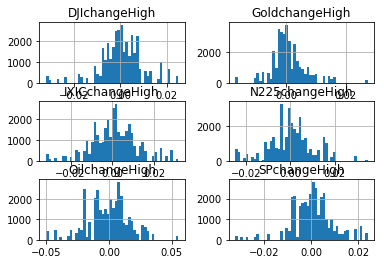

In [14]:
alldata[["SPchangeHigh","OilchangeHigh", 'GoldchangeHigh','IXICchangeHigh', 'DJIchangeHigh','N225changeHigh']].hist(bins=50)

## here we find out difference of the price on day befor and after and call it *nextHigh-yestHigh*

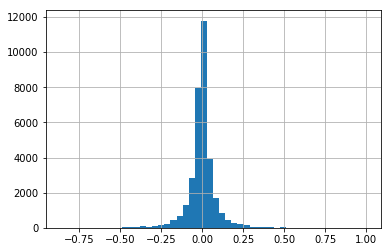

In [10]:
alldata["nextHigh-yestHigh"]=alldata["nextdayHigh"]/alldata["yesterdayHigh"]-1
alldata=alldata[alldata["nextHigh-yestHigh"]<1]
alldata["nextHigh-yestHigh"].hist(bins=50)

### if price is increased (positive), then give it "buy" tag, otherwise "sell" tag

In [11]:
def tagmaker2(x):
    if x>0:
        return "buy"
    else :
        return "sell"
alldata["tag"]=alldata["nextHigh-yestHigh"].apply(lambda x:tagmaker2(x))
alldata["tag"].value_counts()

sell    17141
buy     16412
Name: tag, dtype: int64

## defining requiered functions

In [72]:
def tokenize(text):
    '''this method does the following
    1. normalizing all the words to lower size
    2. removes punctuations
    3. splits the words
    4. removes the stopwords like am,is,have,you,...
    5. lammetizes the words for example running-->run
    '''
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())    # normalize case and remove punctuation
    tokens = word_tokenize(text)    # tokenize text
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]    # lemmatize andremove stop words
    return tokens

def display_results(y_test, y_pred):
    '''
    function to display confusion matrix
    '''
    labels = np.unique(y_pred)
    confusion_mat = confusion_matrix(y_test, y_pred, labels=labels)
    accuracy = (y_pred == y_test).mean()

    print("Labels:", labels)
    print("Confusion Matrix:\n", confusion_mat)
    print("Accuracy:", accuracy)
    df=pd.DataFrame(metrics.confusion_matrix(y_test,y_pred),index=labels,columns=labels)
    return df

## defining features and targets

In [15]:
alldata['desc-title']=alldata['title1']+" "+alldata['desc']
features=alldata[['desc-title','SPchangeHigh',"OilchangeHigh", 'GoldchangeHigh','IXICchangeHigh', 'DJIchangeHigh','N225changeHigh','sector']]
target=alldata['tag']
X_train, X_test, y_train, y_test = train_test_split(features,target,  random_state=444,test_size=.2)
print('rows in the original data set: {}'.format(alldata.shape[0]))
print('rows in the training set: {}'.format(X_train.shape[0]))
print('rows in the test set: {}'.format(X_test.shape[0]))

rows in the original data set: 33553
rows in the training set: 26842
rows in the test set: 6711


In [17]:
features.head(5)

,desc-title,SPchangeHigh,OilchangeHigh,GoldchangeHigh,IXICchangeHigh,DJIchangeHigh,N225changeHigh,sector
0,T. Rowe Price sells most of its Tesla shares T...,0.002152,0.005362,0.000897,0.00804,0.001399,0.005411,Finance
1,Gannett to retain all seats in MNG proxy fight...,0.002152,0.005362,0.000897,0.00804,0.001399,0.005411,Consumer Services
2,"XPO shareholders support exec pay plan, reject...",0.002152,0.005362,0.000897,0.00804,0.001399,0.005411,Consumer Services
3,MacroGenics +13.1% on new data from breast can...,0.002152,0.005362,0.000897,0.00804,0.001399,0.005411,Health Care
4,"Bunge looks to downsize before growing again, ...",0.002152,0.005362,0.000897,0.00804,0.001399,0.005411,Consumer Non-Durables


In [18]:
target.head(5)

0     buy
1    sell
2     buy
3     buy
4    sell
Name: tag, dtype: object

## preprocessing pipeline

In [19]:
preprocess = make_column_transformer(
    (make_pipeline( CountVectorizer(tokenizer=tokenize),TfidfTransformer()),'desc-title'),
    (StandardScaler(),['SPchangeHigh',"OilchangeHigh", 'GoldchangeHigh','IXICchangeHigh', 'DJIchangeHigh']),
    (OneHotEncoder(),['sector']),
)
a=preprocess.fit_transform(features)

In [20]:
a.shape

(33553, 48373)

## model pipeline

In [21]:
def model_pipeline():
    pipeline = Pipeline([
        ('process', preprocess),
        
        ('clf', RandomForestClassifier(random_state = 42))
#         ('clf', GradientBoostingClassifier())
#         ('clf', MultinomialNB())
    ])
    return pipeline


X_train.shape
y_train.shape

(26842,)

## fit model

In [22]:
model = model_pipeline()
model.fit(X_train, y_train);

C:\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


## how model is doing

In [25]:
predictions = model.predict(X_test)
predictions 

array(['buy', 'buy', 'buy', ..., 'sell', 'buy', 'sell'], dtype=object)

In [26]:
display_results(y_test, predictions)

Labels: ['buy' 'sell']
Confusion Matrix:
 [[2070 1176]
 [1689 1776]]
Accuracy: 0.573088958426464


,buy,sell
buy,2070,1176
sell,1689,1776


In [28]:
from sklearn import metrics
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

         buy       0.55      0.64      0.59      3246
        sell       0.60      0.51      0.55      3465

    accuracy                           0.57      6711
   macro avg       0.58      0.58      0.57      6711
weighted avg       0.58      0.57      0.57      6711



In [29]:
predictions = model.predict_proba(X_test)
predictions 

array([[0.6, 0.4],
       [0.6, 0.4],
       [0.9, 0.1],
       ...,
       [0.4, 0.6],
       [0.8, 0.2],
       [0.4, 0.6]])

## fool data

In [61]:
fooldata=pd.read_csv("fool.csv")

In [60]:
fooldata.head()

,title,price,tag
0,Why Williams-Sonoma Stock Popped Today,Shares of were up 11% as of 12:00 p.m. EDT F...,False
1,Why Tailored Brands Stock Dropped 10.5%,Shares of Men's Wearhouse owner stock on Fri...,True
2,Here's Why Mattel Inc Stock Fell Today,Shares of are down 5.9% at 1:50 p.m. on May 3...,False
3,Why Dell Technologies Stock Fell Friday,Shares of information technology and computer ...,False
4,Why Pitney Bowes Stock Dropped 11% on Friday,"It's Friday, and shares of postal solutions pr...",True


In [62]:
def addTag(str):
    if "Crashing" in str:
        return "down"
    if "Got Whacked" in str:
        return "down"
    if "Lower" in str:
        return "down"
    elif "Crashed" in str:
        return "down"
    elif "Lost" in str:
        return "down"
    elif "Crushed" in str:
        return "down"
    elif "Slumped" in str:
        return "down"
    elif "Pop" in str:
        return "down"
    elif "Dropped" in str:
        return "down"
    elif "Drop" in str:
        return "down"
    elif "Fell" in str:
        return "down"
    elif "Fall" in str:
        return "down"
    elif "Fallen" in str:
        return "down"
    elif "Sank" in str:
        return "down"
    elif "Destroyed" in str:
        return "down"
    elif "Tumbling" in str:
        return "down"
    elif "Tumbled" in str:
        return "down"
    elif "Plunged" in str:
        return "down"
    elif "Plunging" in str:
        return "down"
    elif "Plummeted" in str:
        return "down"
    elif "Surge on Debt" in str:
        return "down"
    elif "Down" in str:
        return "down"
    elif "Slipping" in str:
        return "down"
    elif "Slipped" in str:
        return "down"
    elif "Surged" in str:
        return "down"
    elif "Lower" in str:
        return "down"
    elif "Crash" in str:
        return "down"
    elif "Tanking" in str:
        return "down"
    elif "Out of Fashion" in str:
        return "down"
    elif "Sinking" in str:
        return "down"
    elif "Tanking" in str:
        return "down"
    elif "Hammered" in str:
        return "down"
    elif "Hammerring" in str:
        return "down"
    elif "Slammed" in str:
        return "down"
    elif "Slamming" in str:
        return "down"
    elif "Imploding" in str:
        return "down"
    elif "Cratered" in str:
        return "down"
    elif "Cratering" in str:
        return "down"
    elif "Sliding" in str:
        return "down"
    elif "Roller Coaster" in str:
        return "down"
    elif "Were Down" in str:
        return "down"
    elif "Dove" in str:
        return "down"
    elif "in the Doghouse" in str:
        return "down"
    elif "Slumping" in str:
        return "down"
    elif "Slumped" in str:
        return "down"
    elif "Collapsing" in str:
        return "down"
    elif "Collapsed" in str:
        return "down"
    elif "Getting Walloped" in str:
        return "down"
    elif "Mauled" in str:
        return "down"
    elif "Tanked" in str:
        return "down"
    elif "Fizzled" in str:
        return "down"
    elif "Plummeting" in str:
        return "down"
    elif "Stumbled" in str:
        return "down"
    elif "Smashed" in str:
        return "down"
    elif "Slid" in str:
        return "down"
    elif "Rough Day" in str:
        return "down"
    elif "Slides" in str:
        return "down"
    elif "Under Pressure" in str:
        return "down"
    elif "Shrugged Off" in str:
        return "down"
    elif "Declined" in str:
        return "down"
    elif "Fading" in str:
        return "down"
    elif "Sink" in str:
        return "down"
    elif "Moving in Opposite Directions" in str:
        return "down"
    elif "Hit the Skids" in str:
        return "down"
    elif "Dip" in str:
        return "down"
    elif "Broke Out" in str:
        return "down"
    elif "Setback" in str:
        return "down"
    elif "Caught Fire" in str:
        return "down"
    elif "Buckled" in str:
        return "down"
    elif "Lose" in str:
        return "down"
    elif "Gave Back Its Gains" in str:
        return "down"
    elif "Got Dumped" in str:
        return "down"
    elif "Weighed on" in str:
        return "down"
    elif "Getting Thrashed" in str:
        return "down"
    elif "Tank" in str:
        return "down"
    elif "Tumble" in str:
        return "down"
    elif "Taking a Beating" in str:
        return "down"
    elif "Derailed" in str:
        return "down"
    elif "Plunge" in str:
        return "down"
    elif "Stumbling" in str:
        return "down"
    elif "Imploded" in str:
        return "down"
    elif "Losing" in str:
        return "down"
    elif "Nosediving" in str:
        return "down"
    elif "Bad Day" in str:
        return "down"


    elif "Soared" in str:
        return "up"
    elif "Looks Gorgeous" in str:
        return "up"
    elif "Leapt" in str:
        return "up"
    elif "Leaping" in str:
        return "up"
    elif "Soars" in str:
        return "up"
    elif "Soaring" in str:
        return "up"
    elif "Jumped" in str:
        return "up"
    elif "Climbed" in str:
        return "up"
    elif "Rose" in str:
        return "up"
    elif "Rising" in str:
        return "up"
    elif "Gained" in str:
        return "up"
    elif "Skyrocketed" in str:
        return "up"
    elif "Skyrocketing" in str:
        return "up"
    elif "Rocketed" in str:
        return "up"
    elif "Upswing" in str:
        return "up"
    elif "Popped" in str:
        return "up"
    elif "Are Up" in str:
        return "up"
    elif "Are Higher" in str:
        return "up"
    elif "Took Off" in str:
        return "up"
    elif "Climbing" in str:
        return "up"
    elif "Spiked" in str:
        return "up"
    elif "Heating Up" in str:
        return "up"
    elif "Gaining" in str:
        return "up"
    elif "Surging" in str:
        return "up"
    elif "Trading Higher" in str:
        return "up"
    elif "Flying Higher" in str:
        return "up"
    elif "Were Up" in str:
        return "up"
    elif "Moving Higher" in str:
        return "up"
    elif "Jumping" in str:
        return "up"
    elif "Higher" in str:
        return "up"
    elif "Is on the Move" in str:
        return "up"
    elif "on the Rise" in str:
        return "up"
    elif "Accelerating" in str:
        return "up"
    elif "Soar" in str:
        return "up"
    elif "Doubled" in str:
        return "up"
    elif "Doubling" in str:
        return "up"
    elif "Took a Hit" in str:
        return "up"
    elif "Up" in str:
        return "up"
    elif "Took Flight" in str:
        return "up"
    elif "Rebounded" in str:
        return "up"
    elif "Rallied" in str:
        return "up"
    elif "Leaped" in str:
        return "up"
    elif "Advanced" in str:
        return "up"
    elif "Bounced" in str:
        return "up"
    elif "What We Learned" in str:
        return "dont"
    elif "Is On Fire" in str:
        return "up"
    elif "Jump" in str:
        return "up"
    elif "Hit the Sky" in str:
        return "up"
    elif "Skyrocket" in str:
        return "up"
    elif "Rallying" in str:
        return "up"
    elif "Got Cut in Half" in str:
        return "down"
    elif "Hit Vail" in str:
        return "down"
    elif "Obliterated" in str:
        return "down"
    elif "Decline" in str:
        return "down"
    elif "Swooned" in str:
        return "down"
    elif "Struggled" in str:
        return "down"
    elif "Crushing" in str:
        return "down"

    elif "Roaring" in str:
        return "up"
    elif "Rally" in str:
        return "up"
    elif "Rise" in str:
        return "up"
    elif "Rebounding" in str:
        return "up"
    elif "Bouncing Back" in str:
        return "up"
    elif "Good Day" in str:
        return "up"
    elif "Making Gains" in str:
        return "up"
    elif "Got a Lift" in str:
        return "up"
    elif "Spiking" in str:
        return "up"
    elif "Surge" in str:
        return "up"
    elif "Accelerates" in str:
        return "up"
    elif "Rocketing" in str:
        return "up"
    elif "Ascend" in str:
        return "up"
    elif "Cheering" in str:
        return "up"
    elif "Surge" in str:
        return "up"


    # elif "Strong Buy" in str:
    #     return "dont"
    # 
    # elif "What Happened" in str:
    #     return "dont"
    # elif "Sharp Reversal Warranted" in str:
    #     return "dont"
    # elif "Quadrupled Then Halved" in str:
    #     return "dont"
fooldata["tag"]=fooldata["title"].apply(lambda x:addTag(x) )
fooldata.isnull().sum()


title       0
price     159
tag      1174
dtype: int64

In [63]:
fooldata.dropna(inplace=True,axis=0)
fooldata.isnull().sum()

title    0
price    0
tag      0
dtype: int64

In [64]:
fooldata.shape

(14268, 3)

In [65]:
fooldata.columns

Index(['title', 'price', 'tag'], dtype='object')

In [66]:
fooldata = fooldata.rename(columns={'price': 'desc'})

In [67]:
fooldata.columns

Index(['title', 'desc', 'tag'], dtype='object')

In [78]:

features=fooldata["desc"]
target=fooldata['tag']
X_train, X_test, y_train, y_test = train_test_split(features,target,random_state=222,test_size=.2)
print('rows in the original data set: {}'.format(fooldata.shape[0]))
print('rows in the training set: {}'.format(X_train.shape[0]))
print('rows in the test set: {}'.format(X_test.shape[0]))

rows in the original data set: 14268
rows in the training set: 11414
rows in the test set: 2854


In [84]:
def model_pipeline():
    pipeline = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf', RandomForestClassifier(random_state = 42)),
#         ('clf', GradientBoostingClassifier())
#         ('clf', MultinomialNB())
    ])
    return pipeline


model_pipeline = model_pipeline()
print(X_train.shape)
print(y_train.shape)

(11414,)
(11414,)


In [85]:
X_train.head().iloc[0]

"Image source: Square.Shares of mobile payment processor  are getting crushed today, down by 20% as of 11:20 a.m. ET, after the company reported disappointing first-quarter earnings amid rising costs. Adjusted revenue in the first quarter came in at $146 million, up 64% year over year. That was driven by higher gross payment volume of $10.3 billion, which was in turn driven by growth within the existing seller base. That all translated into a net loss of $96.8 million, or $0.29 per share, far below analysts' expectations of $0.09 per share in red ink.Operating expenses soared a gut-wrenching 72% to $207 million in the first quarter. However, $50 million of that total was attributable to a non-recurring litigation accrual. But even without that charge, the bottom line would have still fallen short of investor expectations. As far as guidance goes, second-quarter adjusted revenue is expected to be $151 million to $156 million. For the full year, adjusted revenue should be $615 million to

In [87]:
model.fit(X_train[:,np.newaxis], y_train);

ValueError: Specifying the columns using strings is only supported for pandas DataFrames